# Grupowanie dokumentów

In [2]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=5757a02c19bec72c942f12c39d7954f818e33427ee38f63878ce79d5f1cb90ab
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [3]:
# For the original example of clustering English Wikipedia articles see: https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

# Dla języka polskiego pobieramy kilkanaście artykułów z Wikipedii z trzech różnych grup tematycznych: 
# 1) gatunki drzew, 2) gryzonie, 3) peryferia komputerowe

import wikipedia

wikipedia.set_lang("pl")
art_titles=[
   'Klon_srebrzysty','Dąb_czerwony','Dąb_błotny','Sosna_wejmutka','Świerk_pospolity',
   'Szczur_wędrowny','Szczur_śniady','Mysz_domowa','Suseł_perełkowany','Wiewiórka_pospolita',
   'Mysz_komputerowa','Dżojstik','Klawiatura_komputerowa','Monitor_komputera'
]
art_texts=[]
for ai, art in enumerate(art_titles):
   print("Downloading: {} ({} of {}).".format(art, ai + 1, len(art_titles)))
   art_texts.append(wikipedia.page(art).content)



Downloading: Klon_srebrzysty (1 of 14).
Downloading: Dąb_czerwony (2 of 14).
Downloading: Dąb_błotny (3 of 14).
Downloading: Sosna_wejmutka (4 of 14).
Downloading: Świerk_pospolity (5 of 14).
Downloading: Szczur_wędrowny (6 of 14).
Downloading: Szczur_śniady (7 of 14).
Downloading: Mysz_domowa (8 of 14).
Downloading: Suseł_perełkowany (9 of 14).
Downloading: Wiewiórka_pospolita (10 of 14).
Downloading: Mysz_komputerowa (11 of 14).
Downloading: Dżojstik (12 of 14).
Downloading: Klawiatura_komputerowa (13 of 14).
Downloading: Monitor_komputera (14 of 14).


In [4]:
# Drukujemy przykładowe dokumenty

print(art_texts[0][0:300])
print(art_texts[1][0:450])

Klon srebrzysty (Acer saccharinum L.) – gatunek drzew z rodziny mydleńcowatych (Sapindaceae). W obrębie rodzaju klasyfikowany do sekcji Rubra. Występuje we wschodniej Ameryce Północnej. Jest częstym gatunkiem drzewa w Stanach Zjednoczonych. Do Europy sprowadzony w roku 1725, a do Polski na początku 
Dąb czerwony (Quercus rubra L.) – gatunek drzew z rodziny bukowatych (Fagaceae). Pochodzi ze wschodniej części Ameryki Północnej, w której jest najpospolitszym gatunkiem dębu. W Polsce jest gatunkiem introdukowanym, ok. XIX w. został sprowadzony przez leśników jako gatunek pielęgnacyjny i ochronny. Zaliczany jest do roślin inwazyjnych – niebezpiecznych dla rodzimej flory – i jako taki powinien być usuwany z obszarów chronionych, a także z lasów p


In [5]:
# Tworzymy wektory tf-idf z pobranych dokumentów, zob. moduł 3.3 i 3.8
# W przypadku prawdziwych zbiorów można rozważyć uprzednią lematyzację 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8')
X = vectorizer.fit_transform(art_texts)

# Słownik:
# print({k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])})

# Wagi:
print("IDF\n")
print(vectorizer.idf_)
print("\nTF-IDF\n")
print(X.shape)
print(X.toarray())

IDF

[3.01490302 3.01490302 3.01490302 ... 3.01490302 3.01490302 3.01490302]

TF-IDF

(14, 6445)
[[0.         0.         0.07040202 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [6]:
# Następnie grupujemy dokumenty algorytmem centroidów K-means
from sklearn.cluster import KMeans
import pandas as pd 

max_iterations = 100 # Maksymalna liczba iteracji
n_init = 10 # Liczba przebiegów z różną inicjalizacją centroidów
true_k = 3 # Znana/ przybliżona/ pożądana liczba skupień

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=max_iterations, n_init=n_init)

model.fit(X.toarray())
labels=model.labels_
res_df=pd.DataFrame(list(zip(art_titles,labels)),columns=['title','cluster'])
print(res_df.sort_values(by=['cluster']))

                     title  cluster
5          Szczur_wędrowny        0
6            Szczur_śniady        0
7              Mysz_domowa        0
8        Suseł_perełkowany        0
9      Wiewiórka_pospolita        0
10        Mysz_komputerowa        1
11                Dżojstik        1
12  Klawiatura_komputerowa        1
13       Monitor_komputera        1
0          Klon_srebrzysty        2
1             Dąb_czerwony        2
2               Dąb_błotny        2
3           Sosna_wejmutka        2
4         Świerk_pospolity        2


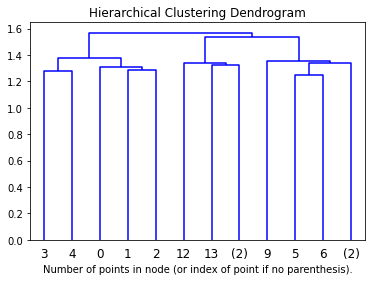

In [7]:
# Przykład klastrowania hierarchicznego skopiowany z: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import numpy as np

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

    
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X.toarray())
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
    
    

In [8]:
# Miary jednorodności i kompletności

from sklearn import metrics

true_labels = [1,1,1,1,1,0,0,0,0,0,2,2,2,2]

print(true_labels)
print(model.labels_)
print(metrics.homogeneity_score(true_labels , model.labels_))
print(metrics.completeness_score(true_labels, model.labels_))
print(metrics.v_measure_score(true_labels , model.labels_))

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2]
[ 8 10  7 11  3 13  9  4  6  1 12  5  2  0]
0.9999999999999996
0.4143050267559162
0.5858778960946418


In [9]:
# Jednorodne ale niekompletne skupienia

true_labels = [1,1,1,0,0,0]
model_labels = [0,0,0,1,1,2]

print(true_labels)
print(model_labels)
print(metrics.homogeneity_score(true_labels , model_labels))
print(metrics.completeness_score(true_labels, model_labels))
print(metrics.v_measure_score(true_labels , model_labels))

[1, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 2]
1.0
0.6853314789615865
0.8132898335036762


In [10]:
# Kompletne ale niejednorodne skupienia

true_labels = [1,1,1,0,0,0]
model_labels = [1,1,1,1,1,1]

print(true_labels)
print(model_labels)
print(metrics.homogeneity_score(true_labels , model_labels))
print(metrics.completeness_score(true_labels, model_labels))
print(metrics.v_measure_score(true_labels , model_labels))

[1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 1, 1]
3.203426503814918e-16
1.0
6.406853007629835e-16


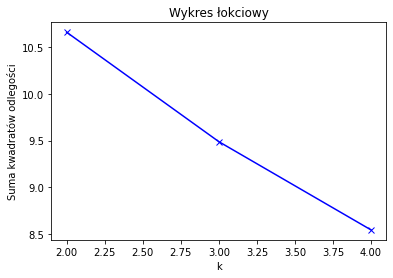

In [11]:
# Poszukiwanie optymalnej liczby skupień
# Zob. https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

import pandas as pd
import matplotlib.pyplot as mplt

sum_of_sq_dist = [] # Suma kwadratów odległości od dokumentów do ich najbliższych centroidów
K = range(2,5)
for k in K:
   km = KMeans(n_clusters=k, max_iter=max_iterations, n_init=n_init)
   km = km.fit(X)
   # Zob. też distortion metric, see: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
   sum_of_sq_dist.append(km.inertia_)
mplt.plot(K, sum_of_sq_dist, 'bx-')
mplt.xlabel('k')
mplt.ylabel('Suma kwadratów odlegości')
mplt.title('Wykres łokciowy')
mplt.show()

In [3]:
# Ciekawszy wykres łokciowy. Zob. https://www.scikit-yb.org/en/latest/api/cluster/elbow.html


In [14]:
!pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68503 sha256=db9d44da1bf85003a5b70bc0f792f22448b4450e981f635c86c24acf2c1e8f6f
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [15]:
from bokeh.io import output_notebook
output_notebook()

def load_data(doc_titles, doc_vectors, max_docs=100):
    vecs = []
    top_titles, tfidf_vecs = [], []
    for dvi, dvc in enumerate(doc_vectors[:max_docs]):
        top_titles.append(doc_titles[dvi])
        tfidf_vecs.append(dvc)     
    return top_titles, np.array(tfidf_vecs)
    
doc_vecs = load_data(art_titles, X.toarray())
#print(doc_vecs)



In [16]:
#Adapted from: https://gist.github.com/RustingSword/f9d78163e96554c6708d96d0a513de25

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LabelSet, HoverTool
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE


def plot_docs(doc_titles, doc_vectors, max_docs=100,perplexity=25):
    
    titles, docvecs = load_data(doc_titles, doc_vectors, max_docs=max_docs)
    tsne = TSNE(n_jobs=4, perplexity=perplexity)
    Y = tsne.fit_transform(docvecs)
    source = ColumnDataSource(data=dict(x=Y[:,0], y=Y[:,1], words=titles))
    hover = HoverTool(tooltips=[("doc", "@docs")])

    TOOLS = ['pan', 'wheel_zoom', 'reset', hover]
    p = figure(title='t-SNE embedding of top ' + str(len(Y)) + ' documents',
            plot_width=1200, plot_height=720, tools=TOOLS)
    p.scatter(x='x', y='y', size=8, source=source)
    labels = LabelSet(x='x', y='y', text='words', level='glyph',
            x_offset=5, y_offset=5, source=source, render_mode='canvas')
    p.add_layout(labels)
    show(p)

plot_docs(art_titles, X.toarray())
    